# Imports

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Model

In [2]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

device = torch.device(device)

In [3]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2),


            nn.Conv2d(in_channels=128, out_channels=200, kernel_size=(3,3), stride=1, padding=0),
            nn.BatchNorm2d(200),
            nn.ReLU(),
            nn.Dropout(0.2)
         )

        self.flatten = nn.Flatten()
        
        self.fc = nn.Sequential(
            nn.Linear(in_features=64*200, out_features=2048),
            nn.BatchNorm1d(num_features=2048),
            nn.Linear(in_features=2048, out_features=10),
            nn.BatchNorm1d(num_features=10)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.flatten(x)
        y = self.fc(x)
        return y
    
model = MNISTClassifier().to(device)

# Load dataset

In [4]:
class MNISTDataset(Dataset):
    def __init__(self, path, transform=None):
        super(MNISTDataset, self).__init__()

        data = pd.read_csv(path)
        self.images = data.values[:,1:].reshape((-1, 28, 28))
        self.labels = data.values[:,0].reshape((-1, 1))
        self.transform = transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = np.reshape(self.images[idx], (28, 28, 1)).astype(np.float32)
        label = torch.tensor(self.labels[idx]).squeeze()

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
train_dataset = MNISTDataset("data/train.csv", transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=False)

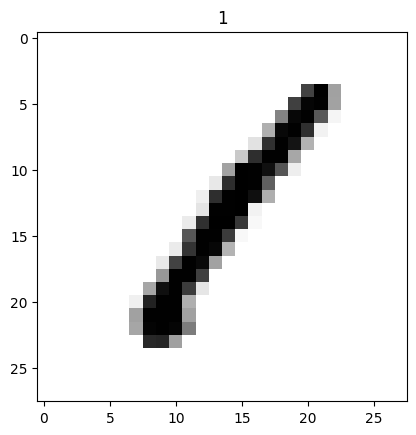

In [6]:
(image, label) = next(iter(train_loader))
plt.title(label[0].numpy())
plt.imshow(image[0].squeeze(), cmap='binary')

# Train

In [7]:
def train_epoch(model, optimizer, loss_fn):
    model.train()

    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)

        outputs = model(X)
        loss = loss_fn(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss = loss.item()
            print(f"\tloss: {loss}")

    

In [8]:
EPOCHS = 10
LEARNING_RATE = 1e-3

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

In [9]:
for epoch in range(1, EPOCHS+1):
    print(f"Epoch {epoch}")
    model.train()

    train_epoch(model, optimizer, loss_fn)

Epoch 1
	loss: 2.86509108543396
	loss: 0.6250989437103271
Epoch 2
	loss: 0.4592243432998657
	loss: 0.4726385772228241
Epoch 3
	loss: 0.3628130853176117
	loss: 0.39375418424606323
Epoch 4
	loss: 0.30256539583206177
	loss: 0.3097207248210907
Epoch 5
	loss: 0.23011913895606995
	loss: 0.27354925870895386
Epoch 6
	loss: 0.2111397534608841
	loss: 0.24947227537631989
Epoch 7
	loss: 0.19143760204315186
	loss: 0.2180376797914505
Epoch 8
	loss: 0.1778251975774765
	loss: 0.19863225519657135
Epoch 9
	loss: 0.14938735961914062
	loss: 0.18698932230472565
Epoch 10
	loss: 0.14356975257396698
	loss: 0.155472993850708


# Submit

In [10]:
class MNISTSubmissionDataset(Dataset):
    def __init__(self, path, transform):
        super(MNISTSubmissionDataset, self).__init__()

        data = pd.read_csv(path)
        self.images = data.values[:,:].reshape((-1, 28, 28))
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = np.reshape(self.images[idx], (28, 28, 1)).astype(np.float32)
        if self.transform:
            image = self.transform(image)

        return image

In [11]:
submission_dataset = MNISTSubmissionDataset("data/test.csv", transform=transforms.ToTensor())
submission_loader = DataLoader(submission_dataset,
                                batch_size=1,
                                shuffle=False)

In [12]:
sample_submission = pd.read_csv("data/sample_submission.csv")

In [13]:
model.eval()
for batch, (X) in enumerate(submission_loader):
    X = X.to(device)
    with torch.no_grad():
        preds = model(X)

        predicted_class = preds.argmax().cpu().numpy()

        start_index = batch * submission_loader.batch_size
        end_index = min(start_index + submission_loader.batch_size, len(sample_submission))
        sample_submission.iloc[start_index:end_index, 1] = predicted_class

In [14]:
sample_submission = sample_submission.set_index("ImageId")
sample_submission.to_csv("data/submission.csv")